In [139]:
# Homework 2 Question 2
# This code was adapted from the starter code supplied

""" Solve
u_t + (u^2 / 2)_x = 0 on [-1, 6]
with fixed boundary conditions.
"""

' Solve\nu_t + (u^2 / 2)_x = 0 on [-1, 6]\nwith fixed boundary conditions.\n'

T = 2
tsteps = 82
    hx = 0.0546875
    ht = 0.0243902
lambda = 0.45


/tmp/ipykernel_30057/2595983597.py:53: RuntimeWarning: overflow encountered in scalar power
  return 0.5 * u**2
/tmp/ipykernel_30057/2595983597.py:60: RuntimeWarning: overflow encountered in scalar multiply
  return 0.5 * (f(uL) + f(uR)) - 0.5 * alpha * (uR - uL)
/tmp/ipykernel_30057/2595983597.py:60: RuntimeWarning: invalid value encountered in scalar subtract
  return 0.5 * (f(uL) + f(uR)) - 0.5 * alpha * (uR - uL)
/tmp/ipykernel_30057/2595983597.py:115: RuntimeWarning: invalid value encountered in scalar add
  uR[j] = u[j] + 0.5 * hx * slope[j]


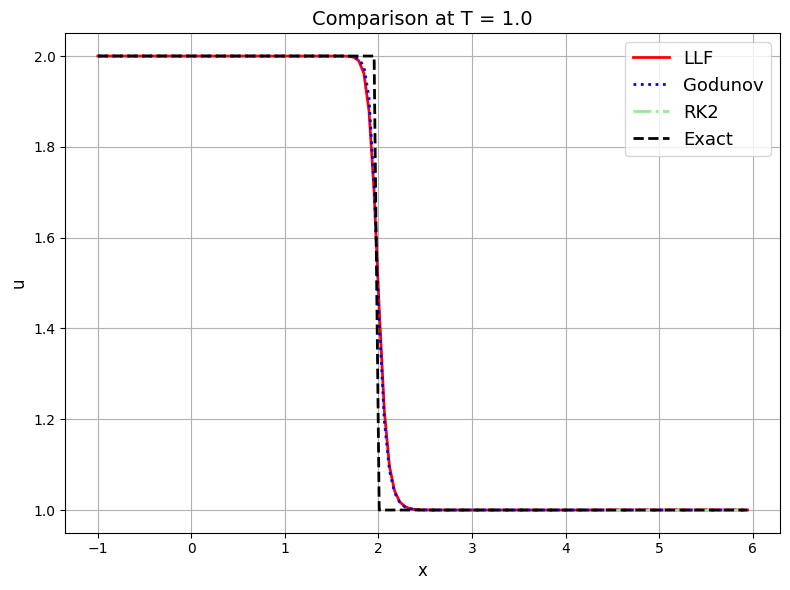

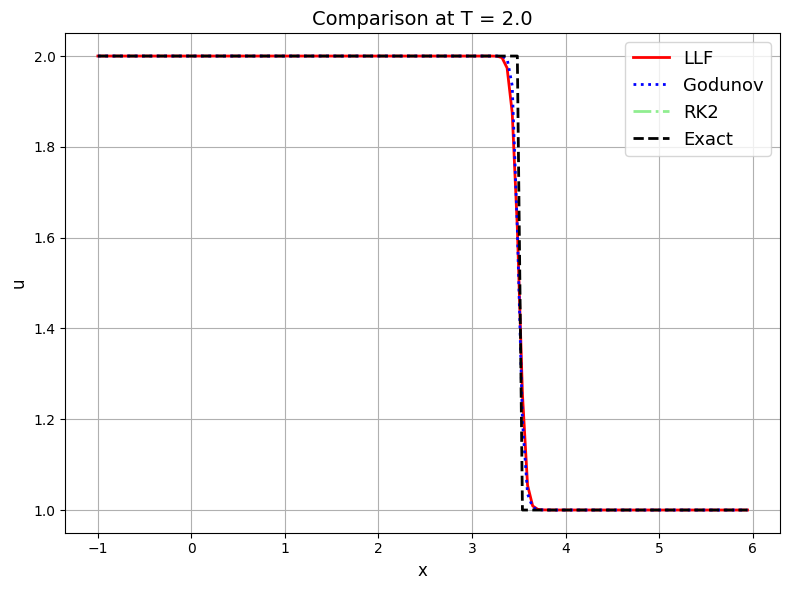

LLF Scheme Relative L2 Error at T = 1.0: 3.503e-02
LLF Scheme Relative L2 Error at T = 2.0: 2.457e-02
Godunov Scheme Relative L2 Error at T = 1.0: 3.274e-02
Godunov Scheme Relative L2 Error at T = 2.0: 2.235e-02
RK2 Scheme Relative L2 Error at T = 1.0: nan
RK2 Scheme Relative L2 Error at T = 2.0: nan


In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Initial Conditions
def step(x):
    u = np.zeros(x.shape)
    for j in range(len(x)):
        if x[j] < 0:
            u[j] = 2.0
        elif (x[j] >= 0) and (x[j] <= 1):
            u[j] = 2.0 - x[j]
        else:
            u[j] = 1.0
    return u

# Exact Rarefaction
def exact_rarefaction(x, t):
    u = np.zeros_like(x)
    if t < 1:
        u[x < 2*t] = 2.0
        mask_linear = (x >= 2*t) & (x <= 1+t)
        u[mask_linear] = (2 - x[mask_linear])/(1-t)
        u[x > 1+t] = 1.0
    else:
        x_s = 2 + 1.5*(t-1)
        u[x < x_s] = 2.0
        u[x >= x_s] = 1.0
    return u

end_time = 2.0
gamma = 0.45 # I changed this from the one in the starter code of 0.9 as that did not satisfy the CFL condition
nx = 128
x, hx = np.linspace(-1, 6, nx, endpoint=False, retstep=True)
# Ghost cell mask: pretend first and last DoF are ghost cells
mask = np.ones(len(x), dtype=bool)
mask[:1] = mask[-1:] = False
# Indexing arrays
K = np.arange(0, nx)    # 0, ..., nx-1
Km1 = np.roll(K, 1)     # nx-1, 0, 1, ..., nx-2
Kp1 = np.roll(K, -1)    # 1, ..., nx
ht = hx * gamma
nt = int(np.ceil(end_time / ht))
ht = end_time / nt
print('T = %g' % end_time)
print('tsteps = %d' % nt)
print('    hx = %g' % hx)
print('    ht = %g' % ht)
print('lambda = %g' % gamma)
u = step(x)
u0 = u.copy()

def f(u):
    return 0.5 * u**2

def fprime(u):
    return u

def flux_LLF(uL, uR):
    alpha = max(abs(fprime(uL)), abs(fprime(uR)))
    return 0.5 * (f(uL) + f(uR)) - 0.5 * alpha * (uR - uL)

# --- Updated LLF flux (Equation (6.59, 6.60, 6.61)) --- #
def update_LLF(u, hx, ht):
    nx = len(u)
    unew = u.copy()
    F = np.zeros(nx + 1)
    for j in range(nx - 1):
        F[j+1] = flux_LLF(u[j], u[j+1])
    for j in range(1, nx - 1):
        unew[j] = u[j] - (ht / hx) * (F[j+1] - F[j])
    unew[0] = 2.0
    unew[-1] = 1.0
    return unew

# --- Updated Godunov flux (Equation (6.72)) --- #
def flux_godunov(uL, uR):
    if uL <= uR:
        return min(f(uL), f(uR))
    elif uL > uR:
        return max(f(uL), f(uR))

def update_Godunov(u, hx, ht):
    nx = len(u)
    unew = u.copy()
    F = np.zeros(nx + 1)
    for j in range(nx - 1):
        F[j+1] = flux_godunov(u[j], u[j+1])
    for j in range(1, nx - 1):
        unew[j] = u[j] - (ht / hx) * (F[j+1] - F[j])
    unew[0] = 2.0
    unew[-1] = 1.0
    return unew

# --- Minmod Slope Limiter (Equation (6.106)) --- #
def minmod(r):
    return max(0.0, min(1.0, r))

def spatial_reconstruct_minmod(u, hx):
    nx = len(u)
    slope = np.zeros(nx)
    for j in range(1, nx - 1):
        dr = (u[j+1] - u[j]) / hx
        dl = (u[j] - u[j-1]) / hx
        if abs(dr) < 1.0e-14:
            slope[j] = 0.0
        else:
            r = dl / dr
            slope[j] = minmod(r) * dr
    uL = np.zeros(nx)
    uR = np.zeros(nx)
    for j in range(nx):
        uL[j] = u[j]
        uR[j] = u[j]
    for j in range(1, nx - 1):
        uR[j] = u[j] + 0.5 * hx * slope[j]
        uL[j] = u[j] - 0.5 * hx * slope[j]
    return uL, uR

def L_operator_LLF(u, hx):
    u[0]  = 2.0
    u[-1] = 1.0
    uL, uR = spatial_reconstruct_minmod(u, hx)
    nx_local = len(u)
    F = np.zeros(nx_local + 1)
    for j in range(nx_local):
        if j + 1 < nx_local:
            F[j+1] = flux_LLF(uR[j], uL[j+1])
    Lu = np.zeros_like(u)
    for j in range(1, nx_local - 1):
        Lu[j] = -(1.0 / hx) * (F[j+1] - F[j])
    Lu[0]  = 0.0
    Lu[-1] = 0.0
    return Lu

def update_RK2(u, hx, ht):
    k1 = L_operator_LLF(u.copy(), hx)
    u_star = u + ht*k1
    k2 = L_operator_LLF(u_star.copy(), hx)
    unew = u + ht*k2
    unew[0]  = 2.0
    unew[-1] = 1.0
    return unew

def solve_scheme(scheme, end_time, gamma, nx):

    x, hx = np.linspace(-1, 6, nx, endpoint=False, retstep=True)
    u = step(x)
    ht = gamma * hx
    nt = int(np.ceil(end_time / ht))
    ht = end_time / nt
    u_t1 = None
    u_t2 = None

    for n in range(1, nt+1):
        t = n * ht
        if scheme == "LLF":
            u = update_LLF(u, hx, ht)
        elif scheme == "Godunov":
            u = update_Godunov(u, hx, ht)
        elif scheme == "RK2":
            u = update_RK2(u, hx, ht)

        if abs(t - 1.0) < 1e-12 or (t > 1.0 and u_t1 is None):
            u_t1 = u.copy()
        if abs(t - 2.0) < 1e-12 or (t > 2.0):
            u_t2 = u.copy()
            break
    return x, u_t1, u_t2

schemes = ["LLF", "Godunov", "RK2"]
solutions = {}
for s in schemes:
    x, sol_t1, sol_t2 = solve_scheme(scheme=s, end_time=end_time, gamma=gamma, nx=nx)
    solutions[s] = (sol_t1, sol_t2)
exact_t1 = exact_rarefaction(x, 1.0)
exact_t2 = exact_rarefaction(x, 2.0)

line_styles = ['-', ':', '-.']
colors = ['red', 'blue', 'lightgreen']

fig1 = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_title("Comparison at T = 1.0", fontsize=14)
for idx, s in enumerate(schemes):
    ax.plot(x, solutions[s][0],
            linestyle=line_styles[idx % len(line_styles)],
            color=colors[idx % len(colors)],
            label=s, linewidth=2)
ax.plot(x, exact_t1, 'k--', linewidth=2, label='Exact')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u', fontsize=12)
ax.legend(loc='best', fontsize=13)
ax.grid(True)
plt.tight_layout()
plt.savefig("u_time_1.png",dpi=300)
plt.show()

fig2 = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_title("Comparison at T = 2.0", fontsize=14)
for idx, s in enumerate(schemes):
    ax.plot(x, solutions[s][1],
            linestyle=line_styles[idx % len(line_styles)],
            color=colors[idx % len(colors)],
            label=s, linewidth=2)
ax.plot(x, exact_t2, 'k--', linewidth=2, label='Exact')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u', fontsize=12)
ax.legend(loc='best', fontsize=13)
ax.grid(True)
plt.tight_layout()
plt.savefig("u_time_2.png",dpi=300)
plt.show()

for s in schemes:
    err_t1 = np.linalg.norm(solutions[s][0] - exact_t1) / np.linalg.norm(exact_t1)
    err_t2 = np.linalg.norm(solutions[s][1] - exact_t2) / np.linalg.norm(exact_t2)
    print(f"{s} Scheme Relative L2 Error at T = 1.0: {err_t1:.3e}")
    print(f"{s} Scheme Relative L2 Error at T = 2.0: {err_t2:.3e}")
